In [3]:
%load_ext autoreload

In [4]:
import math
import numpy as np
import wandb
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.auto import trange
from IPython.display import clear_output

import sys
sys.path.append("..")

In [5]:
%autoreload 2
from samplers import losses
from buffers import ReplayBuffer
from data.datasets_legacy import DatasetSampler, GaussMix
from models.simple_models import SimpleNet, ModelOutput, Energy
from samplers.utils import sample_trajectory
from utils import plot_trajectory, EMA

In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])

def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ], device=mean.device)
    return (R @ mean.T).T

def scatter(tensor, alpha=1.0, label=None, 
            title=None, lim=None, axis_off=True):
    plt.figure(figsize=(5, 5))
    if title is not None:
        plt.title(title)
    if axis_off:
        plt.axis('off')
    plt.scatter(tensor[:, 0], tensor[:, 1], alpha=alpha, label=label)
    if lim is not None:
        plt.xlim(*lim)
        plt.ylim(*lim)

@torch.no_grad()
def draw_level_lines(func, samples=None, lims=(-2, 2), clip_val=(-10, 1000), nsamples: int = 100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)
    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    Z = func(grid_points).reshape(nsamples, nsamples).numpy()

    plt.figure(figsize=(5, 5))
    plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)    
    if samples is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c='r')
    plt.title('- E(x)')
    plt.axis('off')
    plt.show()

def get_drid(lims=(-5, 5), nsamples=100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)
    return torch.from_numpy(grid_points).reshape(-1, 2).float()

def check_grad_is_nan(model, name):
    for n, p in model.named_parameters():
        if torch.isnan(p.grad).any():
            print(f"NaN in {n} grad of {name}")
            return True
    return False

class FixedSizeDataset:
    def __init__(self, dataset):
        self.dataset = dataset
        self.size = dataset.size(0)

    def sample(self, batch_size):
        idxs = torch.randint(0, self.size, (batch_size,))
        return self.dataset[idxs]

def langevin_dynamics(energy, init_step_size=0.0001, n_steps=3001, 
                      num_samples=512, log_interval=500, device="cpu"):
    x = torch.randn(num_samples, 2, device=device)
    trajectory, timesteps = [x], [0]

    for i in range(1, n_steps + 1):
        step_size = init_step_size * (0.1 ** (i / n_steps)) 
        
        # compute gradient
        _x = x.clone().detach().requires_grad_()
        grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
        
        # make a langevin step
        x = x - 0.5 * step_size * grad 
        x = x + torch.randn_like(x) * math.sqrt(step_size)

        if i % log_interval == 0:
            trajectory.append(x)
            timesteps.append(i)

    return trajectory, timesteps

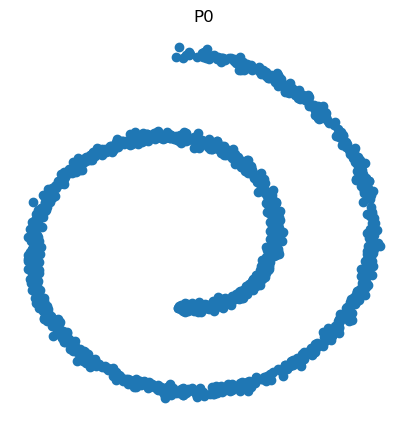

In [7]:
sampler = DatasetSampler(
    p_0='swiss_roll', p_0_args=[None, 0.2, 3.0],
    # p_0='two_circles_custom', p_0_args=[3.0, 1.5, 0.04, 1.0],
    # p_0='two_moons', p_0_args=[None, 0.015, 3.0],
    # p_0='s_curve', p_0_args=[None, 0.02, 3.0],
    p_1='two_circles', p_1_args=[None, 0.02, 3],
)

x_0, x_1 = sampler.sample(128 * 10)

scatter(x_0, axis_off=True, title='P0')

## SB+EBM

In [13]:
@torch.no_grad()
def plot_training_summary(energy, fwd_model, sampler, langevin_samples, 
                          fwd_losses, bwd_losses, energy_losses, 
                          dt, n_steps, t_max, noise_std, n_samples=512):
    fig = plt.figure(figsize=(16, 16))
    
    # Create grid spec for custom layout
    gs = fig.add_gridspec(3, 6, height_ratios=[0.7, 0.7, 0.7])
    
    # Plot 1: Samples x_0 and x_1
    ax1 = fig.add_subplot(gs[0, 0:2])
    with torch.no_grad():
        x_0, _ = sampler.sample(n_samples)
        x_0n = x_0 + torch.randn_like(x_0) * noise_std
        x_1 = sample_trajectory(fwd_model, x_0n, "forward", dt, n_steps, t_max, only_last=True)
    
    ax1.scatter(x_0[:, 0], x_0[:, 1], alpha=0.5, label='(noisy) dataset samples', color='blue')
    ax1.scatter(x_1[:, 0], x_1[:, 1], alpha=0.5, label='samples from the sampler', color='red')
    ax1.legend()
    ax1.set_title('Samples x_0 and x_1')
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)

    # Plot 1.5: Langevin samples
    ax1_and_a_half = fig.add_subplot(gs[0, 4:6])
    ax1_and_a_half.scatter(langevin_samples[:, 0], langevin_samples[:, 1], 
                           alpha=0.5, label='Langevin samples', color='green')
    ax1_and_a_half.legend()
    ax1_and_a_half.set_title('Langevin samples')
    ax1_and_a_half.set_xlim(-5, 5)
    ax1_and_a_half.set_ylim(-5, 5)
    
    # Plot 2: Energy function
    ax2 = fig.add_subplot(gs[0, 2:4])
    limits = (-5, 5)
    x = np.linspace(*limits, 200)
    y = np.linspace(*limits, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X, Y], axis=-1)
    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    
    with torch.no_grad():
        log_density = energy(grid_points).detach()
    
    Z = log_density.numpy().reshape(200, 200)
    
    # contour = ax2.contour(X, Y, Z, levels=7, colors='k')
    # ax2.clabel(contour, inline=True, fontsize=6)
    im = ax2.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)
    ax2.set_title('- E(x)')
    # fig.colorbar(im, ax=ax2, label='Energy Value')
    ax2.set_xlim(*limits)
    ax2.set_ylim(*limits)
    
    # Plot 3: Forward losses
    ax3 = fig.add_subplot(gs[1, 0:3])
    ax3.plot(fwd_losses)
    ax3.set_title('Forward Losses')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Loss')
    ax3.grid(True)
    if min(fwd_losses) < -10 or max(fwd_losses) > 100:
        ax3.set_yscale('symlog')
        ax3.set_ylabel('Loss (symlog scale)')
    
    # Plot 4: Backward losses
    ax4 = fig.add_subplot(gs[1, 3:6])
    ax4.plot(bwd_losses)
    ax4.set_title('Backward Losses')
    ax4.set_xlabel('Iterations')
    ax4.set_ylabel('Loss')
    ax4.grid(True)
    if min(bwd_losses) < -10:
        ax4.set_yscale('symlog')
        ax4.set_ylabel('Loss (symlog scale)')
    
    # Plot 5: Energy losses
    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(energy_losses)
    ax5.set_title('Energy Losses')
    ax5.set_xlabel('Iterations')
    ax5.set_ylabel('Loss')
    ax5.grid(True)
    if min(energy_losses) < -10:
        ax5.set_yscale('symlog')
        ax5.set_ylabel('Loss (symlog scale)')
    
    plt.tight_layout()
    plt.show()

    return fig

def plot_losses(fwd_losses, bwd_losses, energy_losses):
    """
    Plot the three loss curves in a single row.
    
    Args:
        fwd_losses: List of forward process losses
        bwd_losses: List of backward process losses
        energy_losses: List of energy function losses
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot forward losses
    axes[0].plot(fwd_losses)
    axes[0].set_title('Forward Losses')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    if min(fwd_losses) < -10 or max(fwd_losses) > 100:
        axes[0].set_yscale('symlog')
        axes[0].set_ylabel('Loss (symlog scale)')
    
    # Plot backward losses
    axes[1].plot(bwd_losses)
    axes[1].set_title('Backward Losses')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    if min(bwd_losses) < -10:
        axes[1].set_yscale('symlog')
        axes[1].set_ylabel('Loss (symlog scale)')
    
    # Plot energy losses
    axes[2].plot(energy_losses)
    axes[2].set_title('Energy Losses')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)
    if min(energy_losses) < -10:
        axes[2].set_yscale('symlog')
        axes[2].set_ylabel('Loss (symlog scale)')
    
    plt.tight_layout()
    return fig

True 0.2


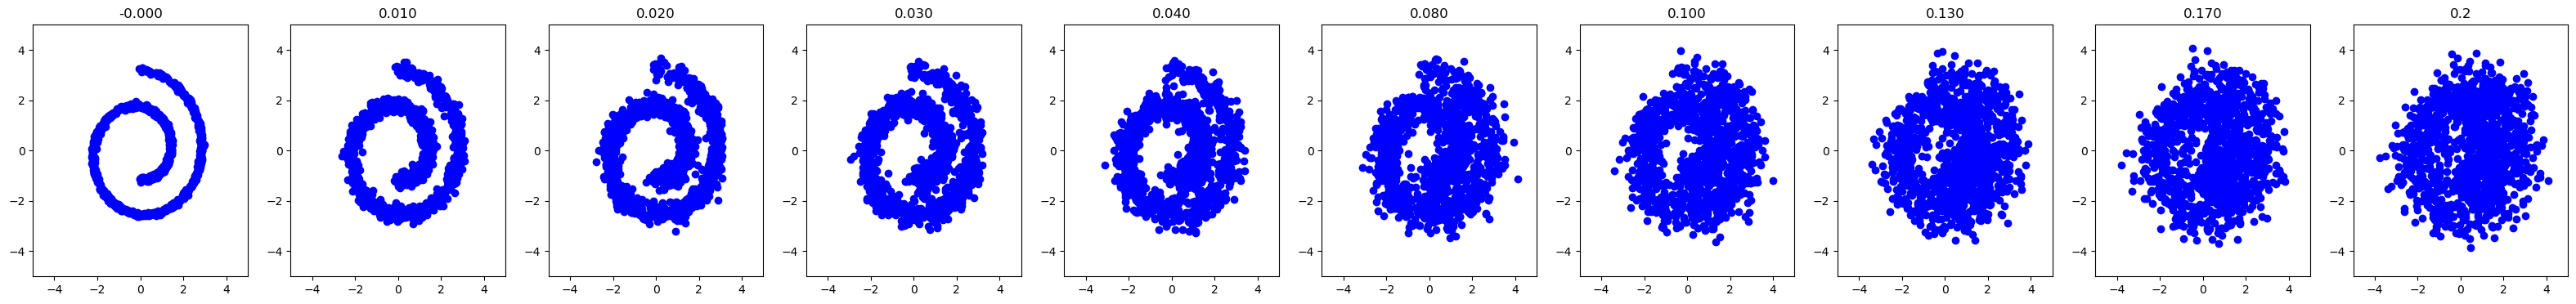

In [14]:
alpha = 0.24
dt = 0.01
t_max = 0.2
n_steps = 20


print(dt * n_steps == t_max, dt * n_steps)


def ref_process(x, t):
    return ModelOutput(drift=-alpha * x)


x_0, _ = sampler.sample(128 * 9)

trajectory, timesteps = sample_trajectory(ref_process, x_0, 'backward', dt, 
                                          n_steps, t_max, return_timesteps=True)

_ = plot_trajectory(trajectory, timesteps[::-1], 
                    indices=[0, 1, 2, 3, 4, 8, 10, -8, -4, -1],
                    limits=(-5, 5))

In [16]:
############ FORWARD AND BACKWARD PROCESSES ############
fwd_model = SimpleNet(64, in_dim=3, 
                      t_emb_size=None,
                      n_main_body_layers=1, 
                      predict_log_var=True)

bwd_model = SimpleNet(64, in_dim=3, 
                      t_emb_size=None,
                      n_main_body_layers=1,
                      predict_log_var=True)

fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=2e-4, weight_decay=1e-5)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=1e-4, weight_decay=1e-5)

num_bwd_iters = 1
num_fwd_iters = 1
num_energy_iters = 1

gamma = 0.4
milestones = [3000, 6000]

fwd_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    fwd_optim, milestones=[3000, 8000, 15_000, 25000, 40000, 50000], gamma=0.7
)
bwd_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    bwd_optim, milestones=[3000, 8000, 15_000, 25000, 40000, 50000], gamma=0.7
)

############ ENERGY ############
energy = Energy(in_dim=2, out_dim=1, 
                hidden_dim=64, 
                n_blocks=1, 
                use_ln=False, 
                block_type='res')

energy_optim = torch.optim.Adam(energy.parameters(), lr=1e-4)
energy_ema = EMA(energy, decay=0.9999, start_update=10_000)
energy_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    energy_optim, milestones=[3000, 8000, 15_000, 25000], gamma=0.7
)

############ OTHER PARAMETERS ############

N_TRAJECTORIES = 2
BATCH_SIZE = 512
N_SB_STEPS = 60_000
WANDB_MODE = "disabled"

data_sampler = FixedSizeDataset(sampler.sample(2048)[0])
p1_buffer = ReplayBuffer(1024, update_fraction=1.0)

fwd_losses, bwd_losses, energy_losses = [], [], []
current_iter = 0


# wandb.init(project="ebm", name="sde-ema", mode=WANDB_MODE)

#### TLM pretaining for SB

In [ ]:
NUM_PRETAIN_STEPS = 2
num_bwd_iters = 2000
num_fwd_iters = 2000

for it in trange(NUM_PRETAIN_STEPS):
    # Sample data
    for _ in range(num_bwd_iters):
        bwd_optim.zero_grad(set_to_none=True)
        x_1 = data_sampler.sample(BATCH_SIZE)
        x_0 = x_1 + torch.randn_like(x1) * 0.07

        _fwd_model = fwd_model if it > 0 else ref_process
        loss = losses.compute_bwd_tlm_loss(
            _fwd_model, bwd_model, x_0, dt, t_max, n_steps
        )
        bwd_optim.step()
        bwd_scheduler.step()

    for _ in trange(num_fwd_iters):
        bwd_optim.zero_grad(set_to_none=True)
        x1 = data_sampler.sample(BATCH_SIZE)

        loss = losses.compute_fwd_tlm_loss(
            fwd_model, bwd_model, x_1, dt, t_max, n_steps
        )
        fwd_optim.step()
        fwd_scheduler.step()

    with torch.no_grad():
        x_1 = data_sampler.sample(BATCH_SIZE)
        x_0 = x_1 + torch.randn_like(x1) * 0.07
        fwd_t, fwd_ts = sample_trajectory(
            fwd_model, x_0, "forward", dt, n_steps, t_max, return_timesteps=True
        )
        bwd_t, bwd_ts = sample_trajectory(
            bwd_model, fwd_t[-1], "backward", dt, n_steps, t_max, return_timesteps=True
        )
        plot_trajectory(
            fwd_t, fwd_ts[::-1], limits=(-5, 5), title="Forward Process"
        )
        plot_trajectory(
            bwd_t, bwd_ts[::-1], limits=(-5, 5), title="Backward Process"
        )
        plt.show()
        plt.close('all')

#### pretrain energy

#### main training

In [ ]:
seed_everything(3704)
logging_frequency = 500
noise_std = 0.6
use_buffer = False
resample_x_0 = True

for it in range(current_iter, N_SB_STEPS):
    current_iter = it    
    x_train = data_sampler.sample(BATCH_SIZE)

    # TRAIN BACKWARD PROCESS
    for _ in range(num_bwd_iters):
        bwd_optim.zero_grad(set_to_none=True)

        if resample_x_0:
            x_train = data_sampler.sample(BATCH_SIZE)
        x_0 = x_train + torch.randn_like(x_train) * noise_std

        loss = losses.compute_bwd_tlm_loss(
            fwd_model, bwd_model, x_0, dt, t_max, n_steps
        )
    
        assert not torch.isnan(loss).any(), "backward loss is NaN"
        check_grad_is_nan(bwd_model, "bwd_model")
        wandb.log({"backward_loss": loss.item()}, step=it)
        wandb.log({"backward_lr": bwd_optim.param_groups[0]["lr"]}, step=it)
        
        bwd_optim.step()
        bwd_scheduler.step()
        
    bwd_losses.append(loss.item())

    # TRAIN FORWARD PROCESS
    for _ in range(num_fwd_iters):
        fwd_optim.zero_grad(set_to_none=True)

        if resample_x_0:
            x_train = data_sampler.sample(BATCH_SIZE)

        x_0 = x_train[:BATCH_SIZE // N_TRAJECTORIES].repeat(N_TRAJECTORIES, 1)
        x_0 = x_0 + torch.randn_like(x_0) * noise_std
        
        loss = losses.compute_fwd_vargrad_loss(
            fwd_model, bwd_model, lambda x: - energy(x),
            x_0, dt, t_max, n_steps, 
            p1_buffer=p1_buffer,
            n_trajectories=N_TRAJECTORIES,
            clip_range=(-10000, 10000)
        )
        
        assert not torch.isnan(loss).any(), "forward loss is NaN"
        loss.backward()
        check_grad_is_nan(fwd_model, "fwd_model")
        wandb.log({"forward_loss": loss.item()}, step=it)
        wandb.log({"forward_lr": fwd_optim.param_groups[0]["lr"]}, step=it)
        
        fwd_optim.step()
        fwd_scheduler.step()

    fwd_losses.append(loss.item())

    # TRAIN ENERGY FUNCTION
    for _ in range(num_energy_iters):
        if resample_x_0:
            x_train = data_sampler.sample(BATCH_SIZE)

        if use_buffer:
            x_1 = p1_buffer.sample(BATCH_SIZE)
        else:
            x_train_noisy = x_train + torch.randn_like(x_train) * noise_std
            x_1 = sample_trajectory(fwd_model, x_train_noisy, "forward", dt, 
                                    n_steps, t_max, only_last=True)

        energy_optim.zero_grad(set_to_none=True)
        loss = losses.ebm_loss(energy, x_train, x_1, alpha=0.0, reg_type='l2')

        assert not torch.isnan(loss).any(), "energy loss is NaN"
        loss.backward()
        check_grad_is_nan(energy, "energy")
        
        wandb.log({"energy_loss": loss.item()}, step=it)
        wandb.log({"energy_lr": energy_optim.param_groups[0]["lr"]}, step=it)

        energy_optim.step()
        energy_ema.update()
        energy_scheduler.step()
    
    energy_losses.append(loss.item())

    # LOG ENERGY FUNCTION
    limits = (-5, 5)
    if it % logging_frequency == 0:
        # clear_output(wait=True)
        print(
            f"Iter={it}, Energy Loss: {loss.item():.3f},", 
            f"energy lr={energy_optim.param_groups[0]['lr']} "
            f"Forward Loss: {loss.item():.3f},", 
            f"forward lr={fwd_optim.param_groups[0]['lr']} ",
            f"backward Loss: {loss.item():.3f},", 
            f"backward lr={bwd_optim.param_groups[0]['lr']}",
        )
        
        with torch.no_grad():
            x_0 = data_sampler.sample(BATCH_SIZE)
            x_0 = x_0 + torch.randn_like(x_0) * noise_std
            
            fwd_trajectory, timesteps = sample_trajectory(
                fwd_model, x_0, "forward", dt, 
                n_steps, t_max, return_timesteps=True
            )
            bwd_trajectory, timesteps = sample_trajectory(
                bwd_model, fwd_trajectory[-1], "backward", 
                dt, n_steps, t_max, return_timesteps=True
            )

        fig_fwd = plot_trajectory(
            fwd_trajectory, timesteps, 
            indices=[0, 1, 2, 3, 4, 5, 7, 10, -7, -5, -3, -1], 
            title="Forward Process", limits=(-5.5, 5.5)
        )
        wandb.log({"forward_trajectory": wandb.Image(fig_fwd)}, step=it)
        plt.show()
        plt.close(fig_fwd)
                
        fig_bwd = plot_trajectory(
            bwd_trajectory, timesteps, 
            indices=[0, 1, 2, 3, 4, 5, 7, 10, -7, -5, -3, -1],
            title="Backward Process", limits=(-5.5, 5.5)
        )
        wandb.log({"backward_trajectory": wandb.Image(fig_bwd)}, step=it)
        plt.show()  
        plt.close(fig_bwd)

        energy_ema.apply_shadow()
        if it % (logging_frequency * 10) == 0:
            samples, tsteps = langevin_dynamics(energy, 0.001, 3000, num_samples=512)
            langevin_fig = plot_trajectory(
                samples, tsteps, 
                title="Langevin sampling", limits=(-5.5, 5.5)
            )
            wandb.log({"langevin_trajectory": wandb.Image(langevin_fig)}, step=it)
            plt.close(langevin_fig)
        
        fig = plot_training_summary(lambda x: -(energy(x).clamp(max=700) - 700), 
                                    fwd_model, sampler, samples[-1],
                                    fwd_losses, bwd_losses, energy_losses, 
                                    dt, n_steps, t_max, noise_std, 
                                    n_samples=BATCH_SIZE)
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        cropped_img = Image.fromarray(image).crop([0, 0, 990, 520])
        plt.close(fig)

        wandb.log({"- energy": wandb.Image(cropped_img)}, step=it)
        energy_ema.restore()

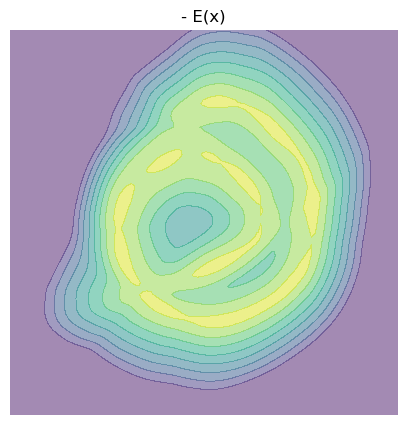

In [30]:
m = 200
draw_level_lines(lambda x: -(energy(x).clamp(max=m) - m), lims=(-5, 5))

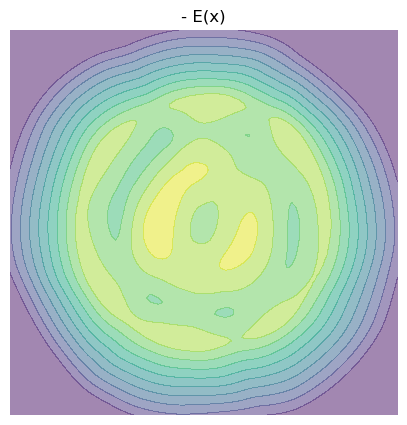

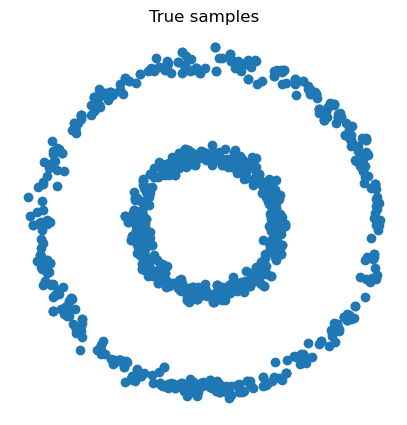

In [78]:
energy_ema.apply_shadow()
x = torch.randn(1024, 2) * 2.1 # Ensure tensor is on the correct device
# trajectory = [x]

init_step_size = 0.001
n_steps = 1500
rate = 750
old_noise = torch.randn_like(x)


# for i in trange(1, n_steps + 1):
#     step_size = init_step_size * (0.1 ** (i / rate)) 
    
#     # compute gradient
#     _x = x.clone().detach().requires_grad_()
#     grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    
#     # make a langevin step
#     new_noise = torch.randn_like(x)
#     x = x - 0.5 * step_size * grad 
#     x = x + 0.5 * (old_noise + new_noise) * math.sqrt(step_size)
#     old_noise = new_noise

# x_true = data_sampler.sample(x.size(0))
m = 41
draw_level_lines(lambda x: m - energy(x).clamp(max=m), lims=(-5, 5))
scatter(x_true, title='True samples')
# scatter(x, alpha=0.5, label='Langevin samples')

energy_ema.restore()

## Run langevin dynamics

In [ ]:
init_step_size = 0.0001
x = torch.zeros(1024, 2)
x = torch.randn_like(x)
x_true = sampler.sample(1024)[0]


for i in range(5001):
    step_size = init_step_size * (0.1 ** (i / 5000))
    if i % 250 == 0:
        plt.figure(figsize=(4, 3))
        scatter(x.detach(), label='current')
        plt.legend()
        plt.show()


    
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    x = x - 0.5 * step_size * grad + torch.randn_like(x) * math.sqrt(step_size)
    


In [110]:
big_sample = sampler.sample(2048 * 2)[0]
def target(x):
    gmm = GaussMix(big_sample, torch.ones_like(big_sample) * 0.002)
    return - gmm.log_prob(x)

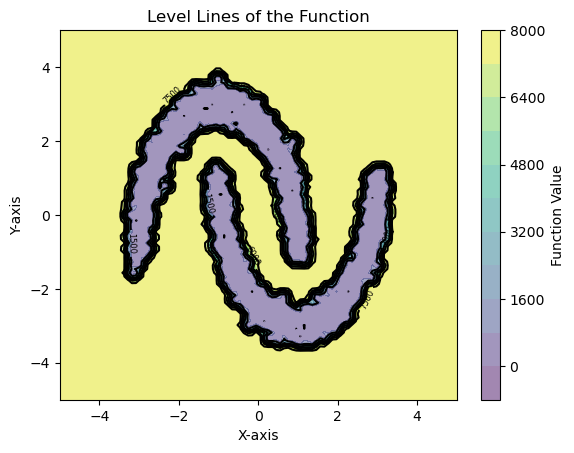

In [116]:
draw_level_lines(lambda x: target(x).clamp(max=8000), lims=(-5, 5))

In [122]:
energy = Energy(in_dim=2, out_dim=1, 
                hidden_dim=256, 
                n_blocks=1, 
                use_ln=False, 
                block_type='simple')
energy_optim = torch.optim.Adam(energy.parameters(), lr=2e-4)

In [146]:
energy_optim.param_groups[0]['lr'] = 5e-3

In [ ]:
for it in range(50_000):
    x = torch.rand(2048, 2) * 10 - 5

    e = energy(x)
    t = target(x)
    loss = (torch.where((t > 8e3) & (e > 8e3), torch.tensor(0.0), torch.tensor(1.0)) * torch.abs(e - t)).mean()
    
    energy_optim.zero_grad()
    loss.backward()
    energy_optim.step()
    
    if it % 1000 == 0:
        print(f'It={it}, loss={loss.item():.3f}')
        draw_level_lines(lambda x: - energy(x).clamp(max=8000), lims=(-5, 5))
        plt.show()


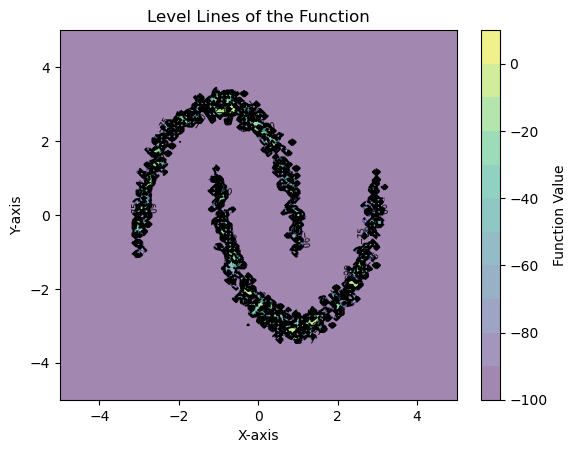

In [145]:
draw_level_lines(lambda x: - target(x).clamp(max=100), lims=(-5, 5))
plt.show()

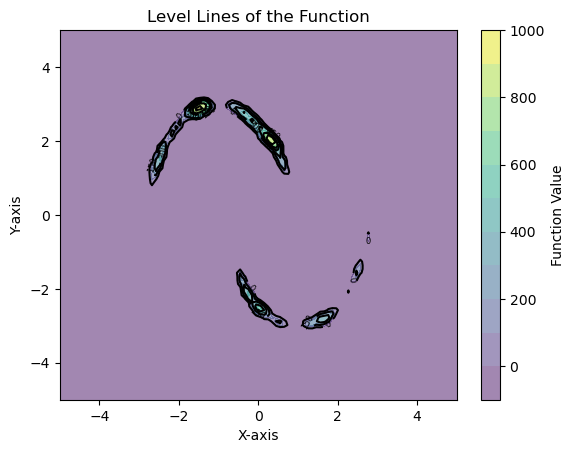

In [144]:
draw_level_lines(lambda x: - energy(x).clamp(max=100), lims=(-5, 5))
plt.show()

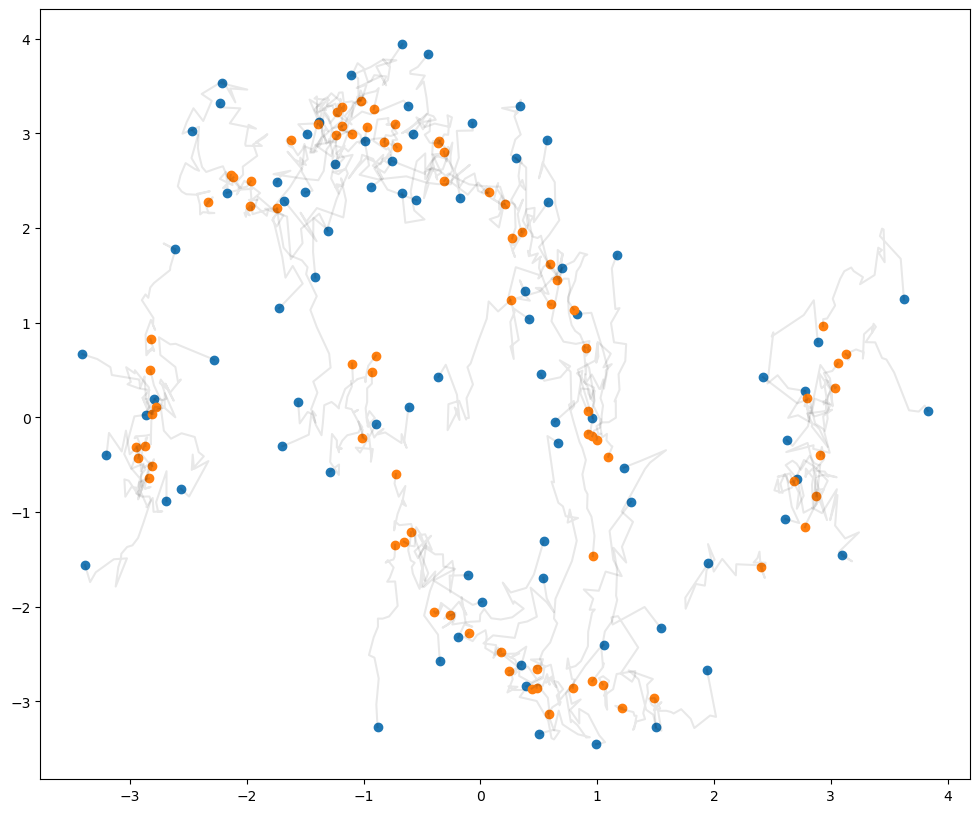

In [83]:
plt.figure(figsize=(12, 10))

n_traj = 80
x_0, x_1, traj = fwd_trajectory[0], fwd_trajectory[-1], np.array(fwd_trajectory).swapaxes(0, 1)
scatter(x_0[:n_traj], label='x_0')
scatter(x_1[:n_traj], label='x_1')

for x in traj[:n_traj]:
    plt.plot(x[:, 0], x[:, 1], color='black', alpha=0.09)

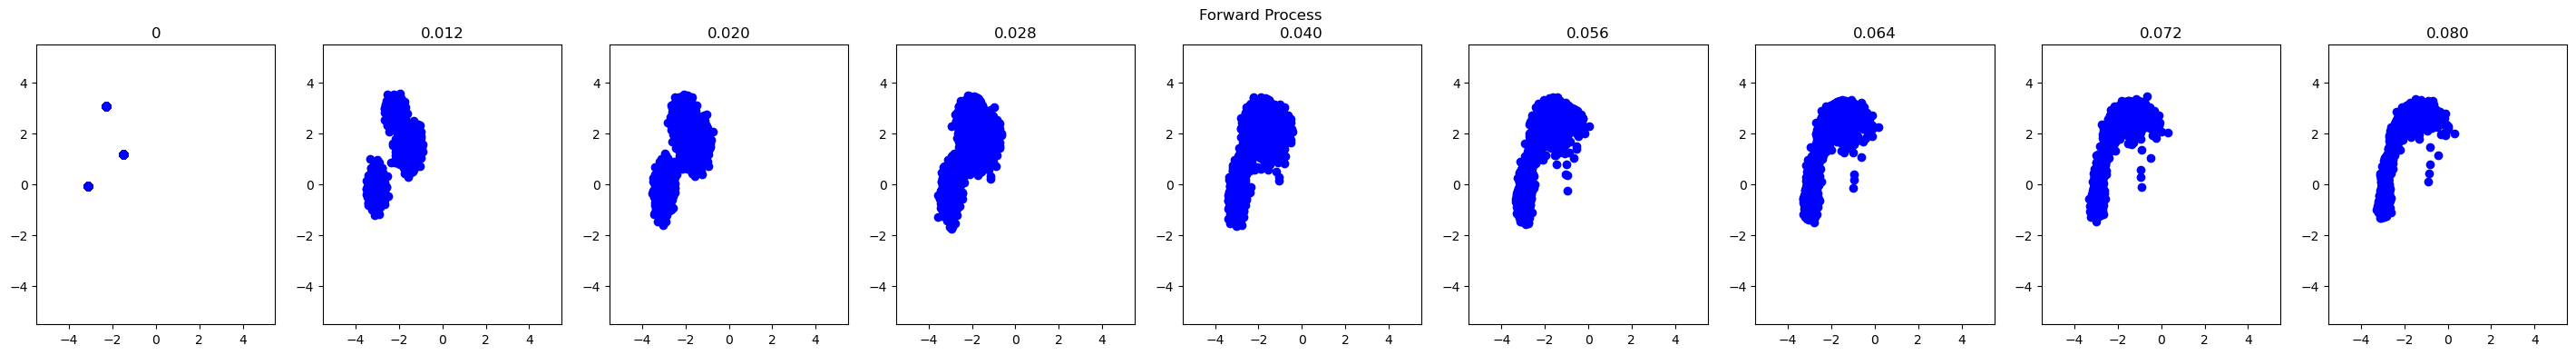

In [88]:
x_0, _ = sampler.sample(8)
x_0 = x_0[:3]
x_0 = x_0 + torch.randn_like(x_0) * noise_std

x_0 = x_0.repeat(2000, 1)

with torch.no_grad():
    fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", dt, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(fwd_trajectory, timesteps, 
                    indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title="Forward Process",
                    limits=(-5.5, 5.5))


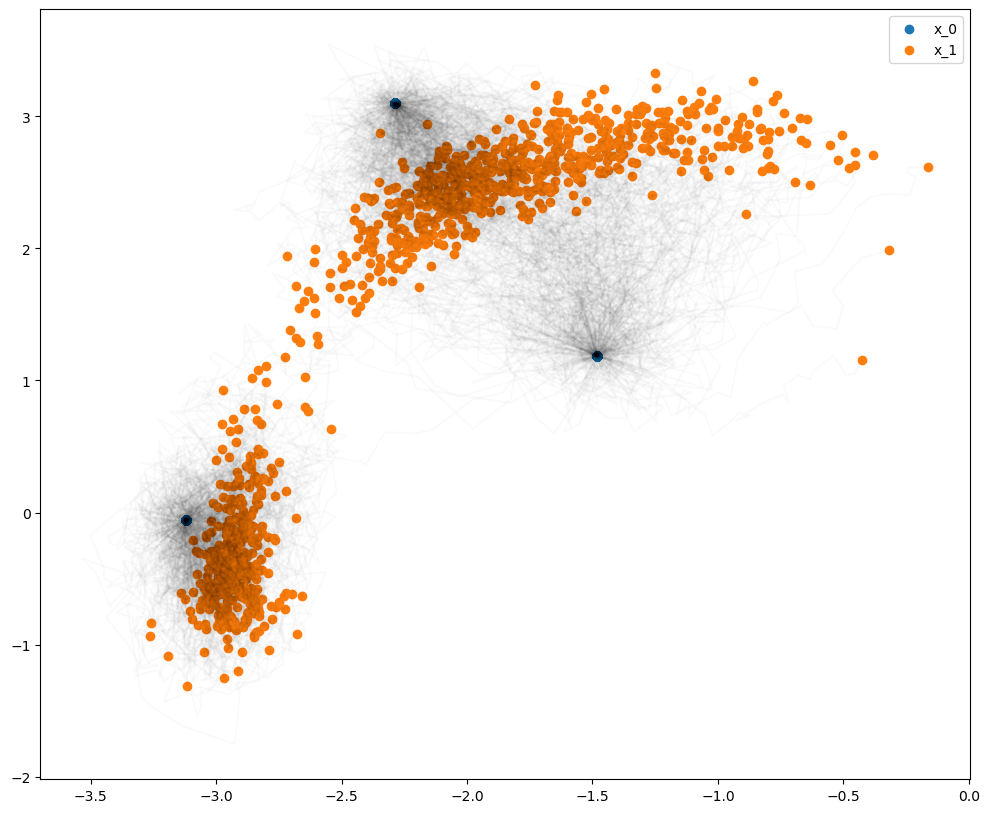

In [89]:
plt.figure(figsize=(12, 10))

n_traj = 1000
x_0, x_1, traj = fwd_trajectory[0], fwd_trajectory[-1], np.array(fwd_trajectory).swapaxes(0, 1)
scatter(x_0[:n_traj], label='x_0')
scatter(x_1[:n_traj], label='x_1')

for x in traj[:n_traj]:
    plt.plot(x[:, 0], x[:, 1], color='black', alpha=0.02)
plt.legend()

## Langevin training of energy

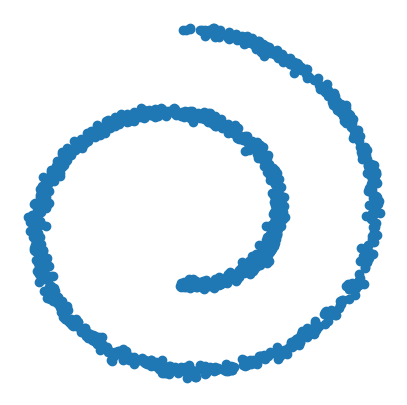

In [8]:
data_sampler = FixedSizeDataset(sampler.sample(2048)[0])
x_0, x_1 = sampler.sample(1280)
scatter(x_0)

In [9]:
energy = Energy(in_dim=2, out_dim=1, hidden_dim=64, 
                n_blocks=1, use_ln=False, 
                block_type='simple')

energy_ema = EMA(energy, decay=0.9999, start_update=30_000)
energy_optim = torch.optim.Adam(
    energy.parameters(), lr=2e-4, 
    weight_decay=0.0
)

energy_loss_array = []

n_iter = 60_000
init_step_size = 0.001
n_langevin_steps = 10

energy_scheduler = torch.optim.lr_scheduler.CyclicLR(
    energy_optim, base_lr=1e-9, max_lr=5e-4, 
    step_size_up=500, step_size_down=7500,
    mode='triangular2'
)

x_fake = torch.randn(512, 2)
old_noise = torch.randn_like(x_fake)
curr_it = 0

#### EBM training techniques

Iter=60000, energy loss: -0.330, lr=2.084329166666667e-06


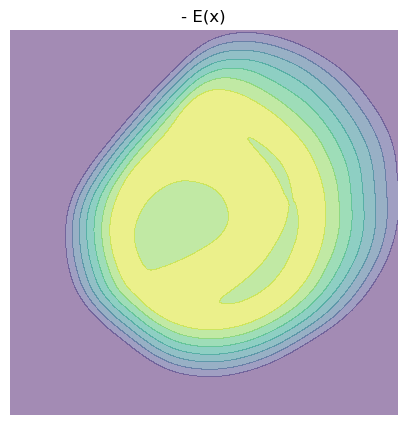

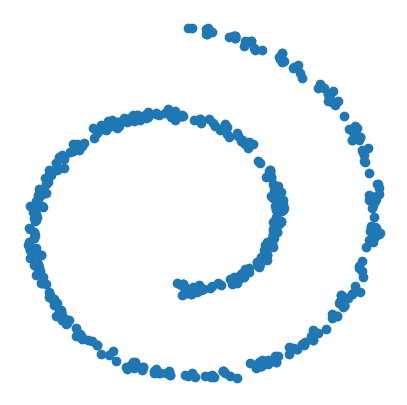

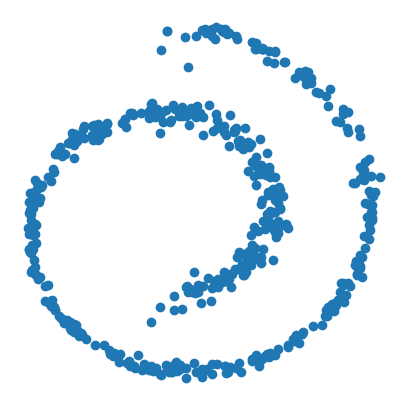

In [10]:
for it in range(1, n_iter + 1):
    curr_it = it
    energy_optim.zero_grad()

    for _ in range(n_langevin_steps):
        # compute gradient
        _x = x_fake.clone().detach().requires_grad_()
        grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
        
        # make a langevin step
        step_size = init_step_size
        new_noise = torch.randn_like(x_fake)
        x_fake = x_fake - 0.5 * step_size * grad 
        x_fake = x_fake + 0.5 * (new_noise + old_noise) * math.sqrt(step_size)
        old_noise = new_noise

    x_true = data_sampler.sample(512)
    energy_loss = losses.ebm_loss(energy, x_true, x_fake, alpha=0.0, reg_type='l2')
    energy_loss.backward()
    energy_optim.step()

    energy_scheduler.step()
    energy_ema.update()

    energy_loss_array.append(energy_loss.item())

    if it == 1 or it % 1_000 == 0:
        clear_output(wait=True)
        energy_ema.apply_shadow()
        current_lr = energy_optim.param_groups[0]['lr']
        print(f"Iter={it}, energy loss: {energy_loss:.3f}, lr={current_lr}", flush=True)
        m = 100
        draw_level_lines(lambda x: m - energy(x).clip(max=m), lims=(-5, 5))
        scatter(x_true)
        scatter(x_fake)
        plt.show()
        energy_ema.restore()

energy_ema.apply_shadow()

In [ ]:
# energy_ema.apply_shadow()
# energy.save(...)
# energy_ema.restore()

#### EBM sampling

Basic LD, BAOAB limit

In [1]:
def compute_acc_ratio(*args, **kwargs):
    return 1.0

  0%|          | 0/100 [00:00<?, ?it/s]

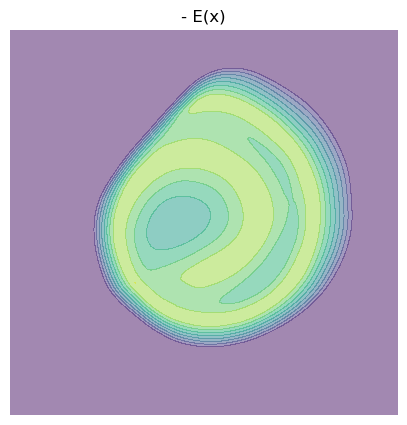

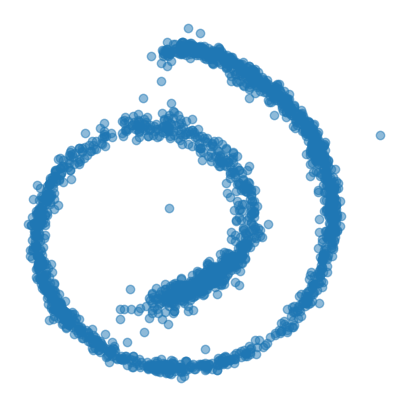

In [77]:
x = torch.randn(2048, 2) * 6.8 # Ensure tensor is on the correct device

beta = 1.0
init_step_size = 0.00002
# init_step_size = 0.01
n_steps = 100
rate = 2500

use_baoab_limit = False
use_mh_adjustment = False
use_preconditioning = True
acc_ratios = []

old_noise = torch.randn_like(x_fake)
for i in trange(1, n_steps + 1):
    step_size = init_step_size #* (0.01 ** (i / rate)) 
    
    # compute gradient
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    
    # make a langevin step
    new_noise = torch.randn_like(x)
    curr_step_noise = 0.5 * (new_noise + old_noise) if use_baoab_limit else new_noise

    if use_preconditioning:
        M_inverse = torch.bmm(grad.unsqueeze(-1), grad.unsqueeze(1)).mean(0)  # g @ g.T
        M_inverse_sqrt = torch.linalg.cholesky(M_inverse)
    else:
        M_inverse = torch.eye(2, device=x.device)
        M_inverse_sqrt = torch.eye(2, device=x.device)
    
    cond_grad = (grad @ M_inverse.T)
    cond_noise = curr_step_noise @ M_inverse_sqrt.T
    x_new = x - 0.5 * step_size * cond_grad + math.sqrt(step_size) * cond_noise

    if use_mh_adjustment:
        acc_ratio = compute_acc_ratio(x_new, x, energy)
        
        acc_ratios.append(acc_ratio.mean().detach())
        acc_mask = torch.rand_like(acc_ratio) < acc_ratio
        x[acc_mask] = x_new[acc_mask]
    else:
        x = x_new
    
    old_noise = new_noise

m = 30
draw_level_lines(lambda x: m - energy(x).clamp(max=m), lims=(-5, 5))
scatter(x, alpha=0.5, label='Langevin samples')

Underdamped LD, BAOAB scheme

  0%|          | 0/1500 [00:00<?, ?it/s]

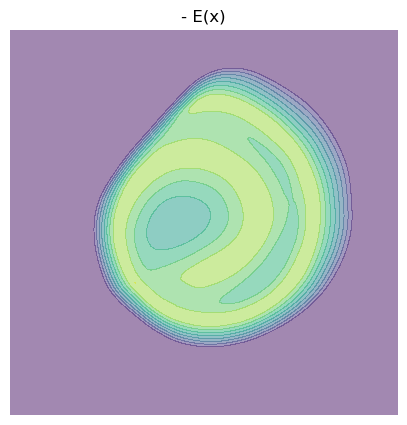

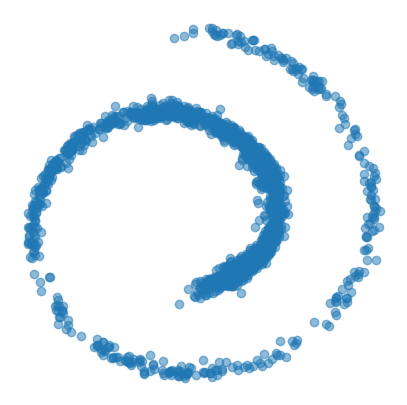

In [54]:
x = torch.randn(2048, 2)  # Ensure tensor is on the correct device
p = torch.randn(2048, 2)

beta = 1.0
init_step_size = 0.004
n_steps = 1500
rate = 2500
damp_gamma = 1.2

use_preconditioning = True

for i in trange(1, n_steps + 1):
    step_size = init_step_size #* (0.01 ** (i / rate)) 
    
    # compute gradient
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]

    # make a BAOAB step
    # B step
    p = p - grad * step_size / 2
    # A step
    x = x + p * step_size / 2
    # O step
    p = p * math.exp(- damp_gamma * step_size) 
    p = p + math.sqrt(1 / (2 * damp_gamma) * (1 - math.exp(-2 * damp_gamma * step_size / beta))) * torch.randn_like(p)
    # A step
    x = x + p * step_size / 2
    # B step
    p = p - grad * step_size / 2

m = 30
draw_level_lines(lambda x: m - energy(x).clamp(max=m), lims=(-5, 5))
scatter(x, alpha=0.5, label='Langevin samples')

Adaptive preconditioning

  0%|          | 0/1000 [00:00<?, ?it/s]

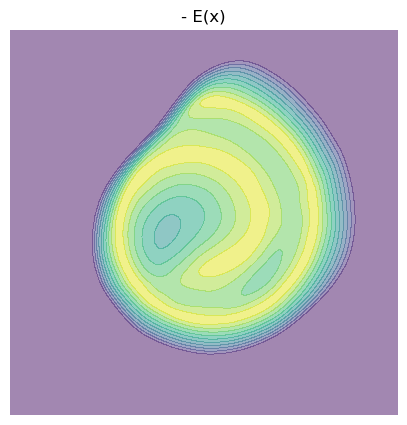

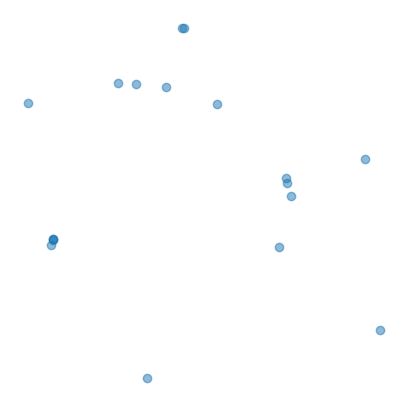

In [128]:
x = torch.randn(2048, 2)  # Ensure tensor is on the correct device
p = torch.randn(2048, 2)

beta = 1.0
init_step_size = 0.004
n_steps = 1000
rate = 2500
damp_gamma = 1.5

for i in trange(1, n_steps + 1):
    step_size = init_step_size #* (0.01 ** (i / rate)) 
    
    # compute gradient
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    M_inv = torch.bmm(grad.unsqueeze(2), grad.unsqueeze(1))
    # M_inv = torch.eye(2, device=x.device).unsqueeze(0).repeat(2048, 1, 1)

    # make a BAOAB step
    # B step
    p = p - grad * step_size / 2
    # A step
    precond_p = torch.bmm(M_inv, p.unsqueeze(2)).squeeze(2)
    x = x + precond_p * step_size / 2
    # O step
    p = precond_p * math.exp(- damp_gamma * step_size) 
    p = p + math.sqrt(1 / (2 * damp_gamma) * (1 - math.exp(-2 * damp_gamma * step_size / beta))) * torch.randn_like(p)
    # A step
    x = x + torch.bmm(M_inv, p.unsqueeze(2)).squeeze(2) * step_size / 2
    # B step
    p = p - grad * step_size / 2

m = 30
draw_level_lines(lambda x: m - energy(x).clamp(max=m), lims=(-5, 5))
scatter(x, alpha=0.5, label='Langevin samples')

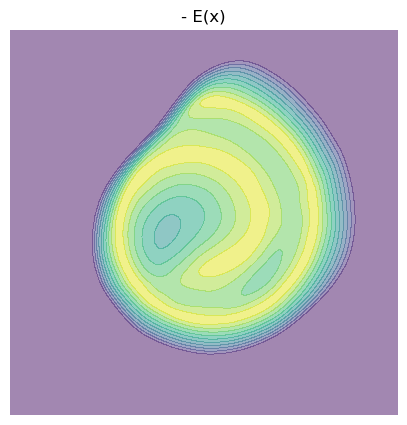

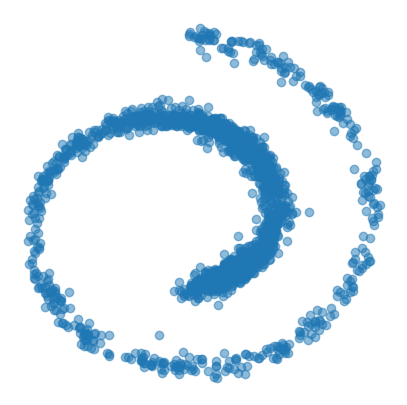

In [104]:
m = 30
draw_level_lines(lambda x: m - energy(x).clamp(max=m), lims=(-5, 5))
scatter(x, alpha=0.5, label='Langevin samples')

Underdampted LD

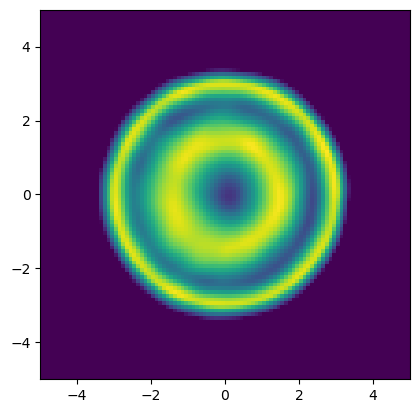

In [74]:
X = torch.linspace(-5, 5, 100)
Y = torch.linspace(-5, 5, 100)
X, Y = torch.meshgrid(X, Y)
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1)
e = - energy(grid_points).detach().reshape(100, 100)
e = (e - e.max()).clamp(min=-10)
plt.imshow(e.T, extent=(-5, 5, -5, 5))

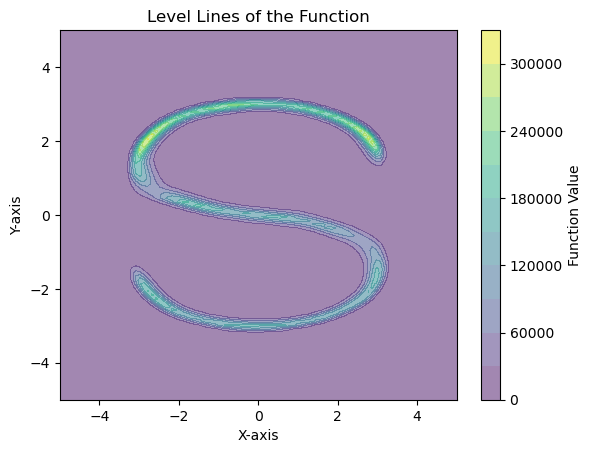

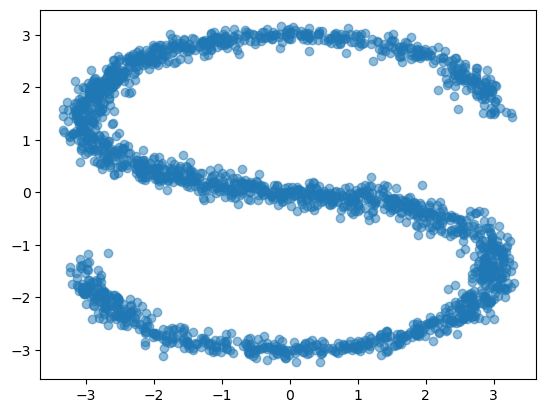

In [ ]:
x = torch.randn(2048, 2) * 2 
init_step_size = 1.0
n_steps = 5000
rate = 2500
for i in range(1, n_steps + 1):
    step_size = init_step_size * (0.01 ** (i / rate)) 
    
    # compute gradient
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    
    # make a langevin step
    x = x - 0.5 * step_size * grad 
    x = x + torch.randn_like(x) * math.sqrt(step_size)

    if i % 1000 == 0:
        trajectory.append(x)

draw_level_lines(lambda x: torch.exp(- energy(x)), lims=(-5, 5))
scatter(trajectory[-1], alpha=0.5, label='Langevin samples')

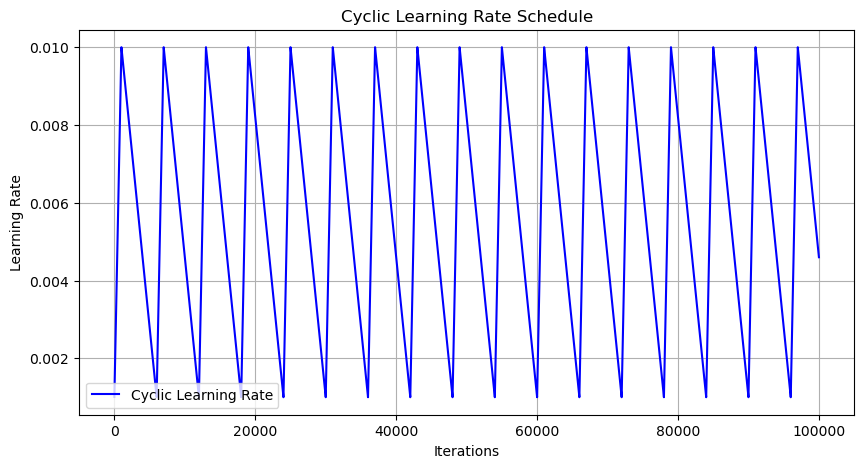

In [90]:
import torch
import matplotlib.pyplot as plt

# Dummy model parameter
param = torch.nn.Parameter(torch.randn(1))

# Define optimizer
optimizer = torch.optim.Adam([param], lr=0.001)  # Base learning rate

# Define CyclicLR scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer, 
    base_lr=0.001,    # Minimum LR
    max_lr=0.01,      # Maximum LR
    step_size_up=1000, # Steps to reach max LR
    step_size_down=5000, # Steps to reach min LR
    mode='triangular' # Choose between 'triangular', 'triangular2', 'exp_range'
)

# Store learning rates
lrs = []
iterations = 100_000  # Total iterations to visualize

for i in range(iterations):
    optimizer.step()  # Dummy step
    scheduler.step()  # Update LR
    lrs.append(optimizer.param_groups[0]['lr'])  # Store current LR

# Plot the LR schedule
plt.figure(figsize=(10, 5))
plt.plot(range(iterations), lrs, label="Cyclic Learning Rate", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.title("Cyclic Learning Rate Schedule")
plt.legend()
plt.grid()
plt.show()

## Wheel energy

In [174]:
from torch.distributions import MultivariateNormal, Categorical

In [212]:
angle = torch.pi / 4
c, s = math.cos(angle), math.sin(angle)
rot = torch.tensor([[c, -s],
                    [s,  c]])

In [232]:
covs

[tensor([[3.0000, 0.0000],
         [0.0000, 0.3000]]),
 tensor([[1.3125, 0.0880],
         [0.0880, 0.3443]]),
 tensor([[0.8400, 0.1525],
         [0.1525, 0.4038]]),
 tensor([[0.6176, 0.2157],
         [0.2157, 0.4884]]),
 tensor([[0.4884, 0.2876],
         [0.2876, 0.6176]]),
 tensor([[0.4038, 0.3812],
         [0.3812, 0.8400]]),
 tensor([[0.3443, 0.5279],
         [0.5279, 1.3125]]),
 tensor([[0.3000, 0.8693],
         [0.8693, 3.0000]])]

In [235]:
angles = torch.linspace(-math.pi / 2, math.pi / 2, 8)
torch.cos(angles)

tensor([-4.3711e-08,  4.3388e-01,  7.8183e-01,  9.7493e-01,  9.7493e-01,
         7.8183e-01,  4.3388e-01, -4.3711e-08])

In [250]:
covs

[tensor([[ 1.1000e+00, -1.9548e-09],
         [-1.9548e-09,  2.2000e-03]]),
 tensor([[0.0066, 0.0037],
         [0.0037, 0.0033]]),
 tensor([[0.0033, 0.0037],
         [0.0037, 0.0066]]),
 tensor([[ 2.2000e-03, -1.9548e-09],
         [-1.9548e-09,  1.1000e+00]])]

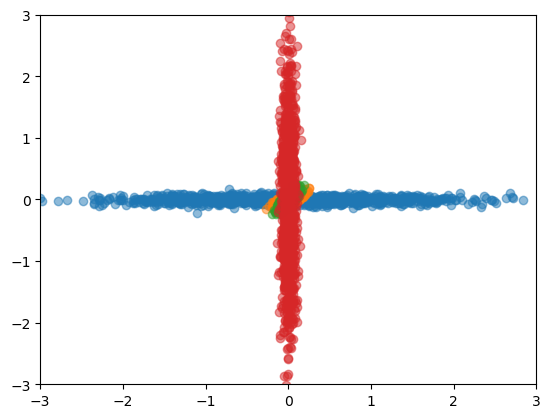

In [249]:
n_dists = 4
angles = torch.linspace(-math.pi / 2, math.pi / 2, n_dists)
sigmas = torch.linspace(1, 500, n_dists).reciprocal()

covs = [
    torch.tensor(
        [[1.1 * sigmas[i], math.cos(angles[i]) * math.sqrt(sigmas[i] * sigmas[n_dists - 1 - i])], 
         [math.cos(angles[i]) * math.sqrt(sigmas[i] * sigmas[n_dists - 1 - i]), 1.1*sigmas[n_dists - 1 - i]]]
    ) for i in range(n_dists)]

for cov in covs:
    g = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=cov)
    samples = g.sample((1000,))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)


In [195]:
corr = 0.99
cov = torch.tensor([
    [1.0, corr], 
    [corr, 1.0]]
)

In [ ]:
n_bars = 8
corr = 0.99
cov = torch.tensor([
    [1.0, corr], 
    [corr, 1.0]]
)
angles = torch.linspace(0, 2 * torch.pi, n_bars + 1)[:-1]
means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=-1)
cov = torch.stack([torch.tensor([
    [math.cos(), -math.sin()],
    []
]) for a in angles], dim=0) * 0.005

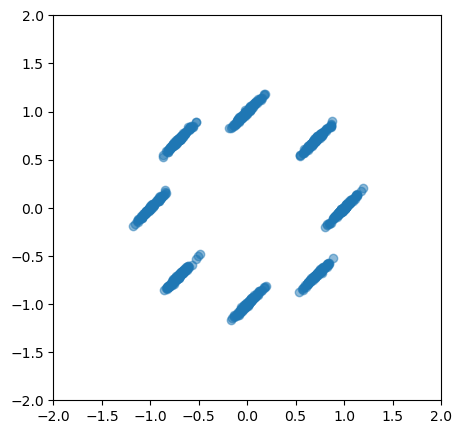

In [199]:
class MixtureOfNormal:
    def __init__(self, means, covs):
        n_comp = means.size(0)
        self.cat = Categorical(torch.ones(n_comp) / n_comp)
        self.mvns = MultivariateNormal(means, covs)
    
    def sample(self, n_samples):
        idxs = self.cat.sample((n_samples,))
        samples = self.mvns.sample((n_samples,))
        return samples[torch.arange(n_samples), idxs]
    
mix = MixtureOfNormal(means, cov)
scatter(mix.sample(1000), alpha=0.5, lim=(-2, 2),
        label='Samples from Gaussian Mixture', axis_off=False)